In [146]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm

In [29]:
!pip install missingno

  Using cached missingno-0.5.2-py3-none-any.whl (8.7 kB)
  Using cached scipy-1.11.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (36.4 MB)


In [30]:
import missingno as msno

# Entendendo a base de dados

In [2]:
adult = pd.read_csv(
    "./train_data.csv",
    sep=r'\s*,\s*',
    engine='python',
    na_values="?"
)

In [3]:
adult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Id              32560 non-null  int64 
 1   age             32560 non-null  int64 
 2   workclass       30724 non-null  object
 3   fnlwgt          32560 non-null  int64 
 4   education       32560 non-null  object
 5   education.num   32560 non-null  int64 
 6   marital.status  32560 non-null  object
 7   occupation      30717 non-null  object
 8   relationship    32560 non-null  object
 9   race            32560 non-null  object
 10  sex             32560 non-null  object
 11  capital.gain    32560 non-null  int64 
 12  capital.loss    32560 non-null  int64 
 13  hours.per.week  32560 non-null  int64 
 14  native.country  31977 non-null  object
 15  income          32560 non-null  object
dtypes: int64(7), object(9)
memory usage: 4.0+ MB


In [4]:
adult.head() # Vendo algumas linhas do dataset para entender melhor

,Id,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,16280,34,Private,204991,Some-college,10,Divorced,Exec-managerial,Own-child,White,Male,0,0,44,United-States,<=50K
1,16281,58,Local-gov,310085,10th,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
2,16282,25,Private,146117,Some-college,10,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,42,United-States,<=50K
3,16283,24,Private,138938,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
4,16284,57,Self-emp-inc,258883,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,5178,0,60,Hungary,>50K


In [6]:
adult.set_index('Id', inplace=True) # Configurando a coluna de identificadores

## Estudando a proporção de labels target

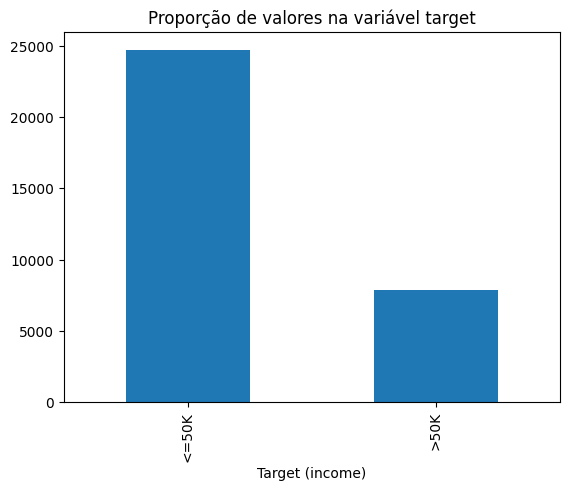

In [55]:
plt.title("Proporção de valores na variável target")
adult['income'].value_counts().plot(kind='bar')
plt.xlabel("Target (income)")
plt.show()

É possível perceber que há um desbalanceamento dos dados, o que talvez traga a necessidade de algum tipo de tratamento 

## Inspecionando dados nulos

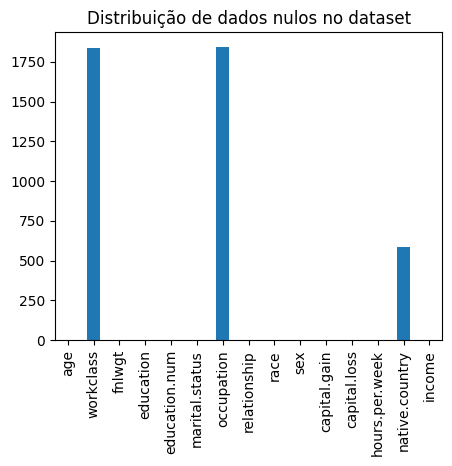

In [17]:
plt.figure(figsize=(5, 4))
plt.title("Distribuição de dados nulos no dataset")
adult.isna().sum().plot(kind='bar')
plt.show()

In [89]:
1 - adult.dropna().shape[0] / adult.shape[0] # Porcentagem de dados nuklos

0.07367936117936114

Percebe-se que as colunas workclass, occupation e native.country têm dados nulos, mas são poucos dados em relação ao dataset inteiro, logo seria possível removê-los. No entanto, também é possivel tentar encontrar padrões

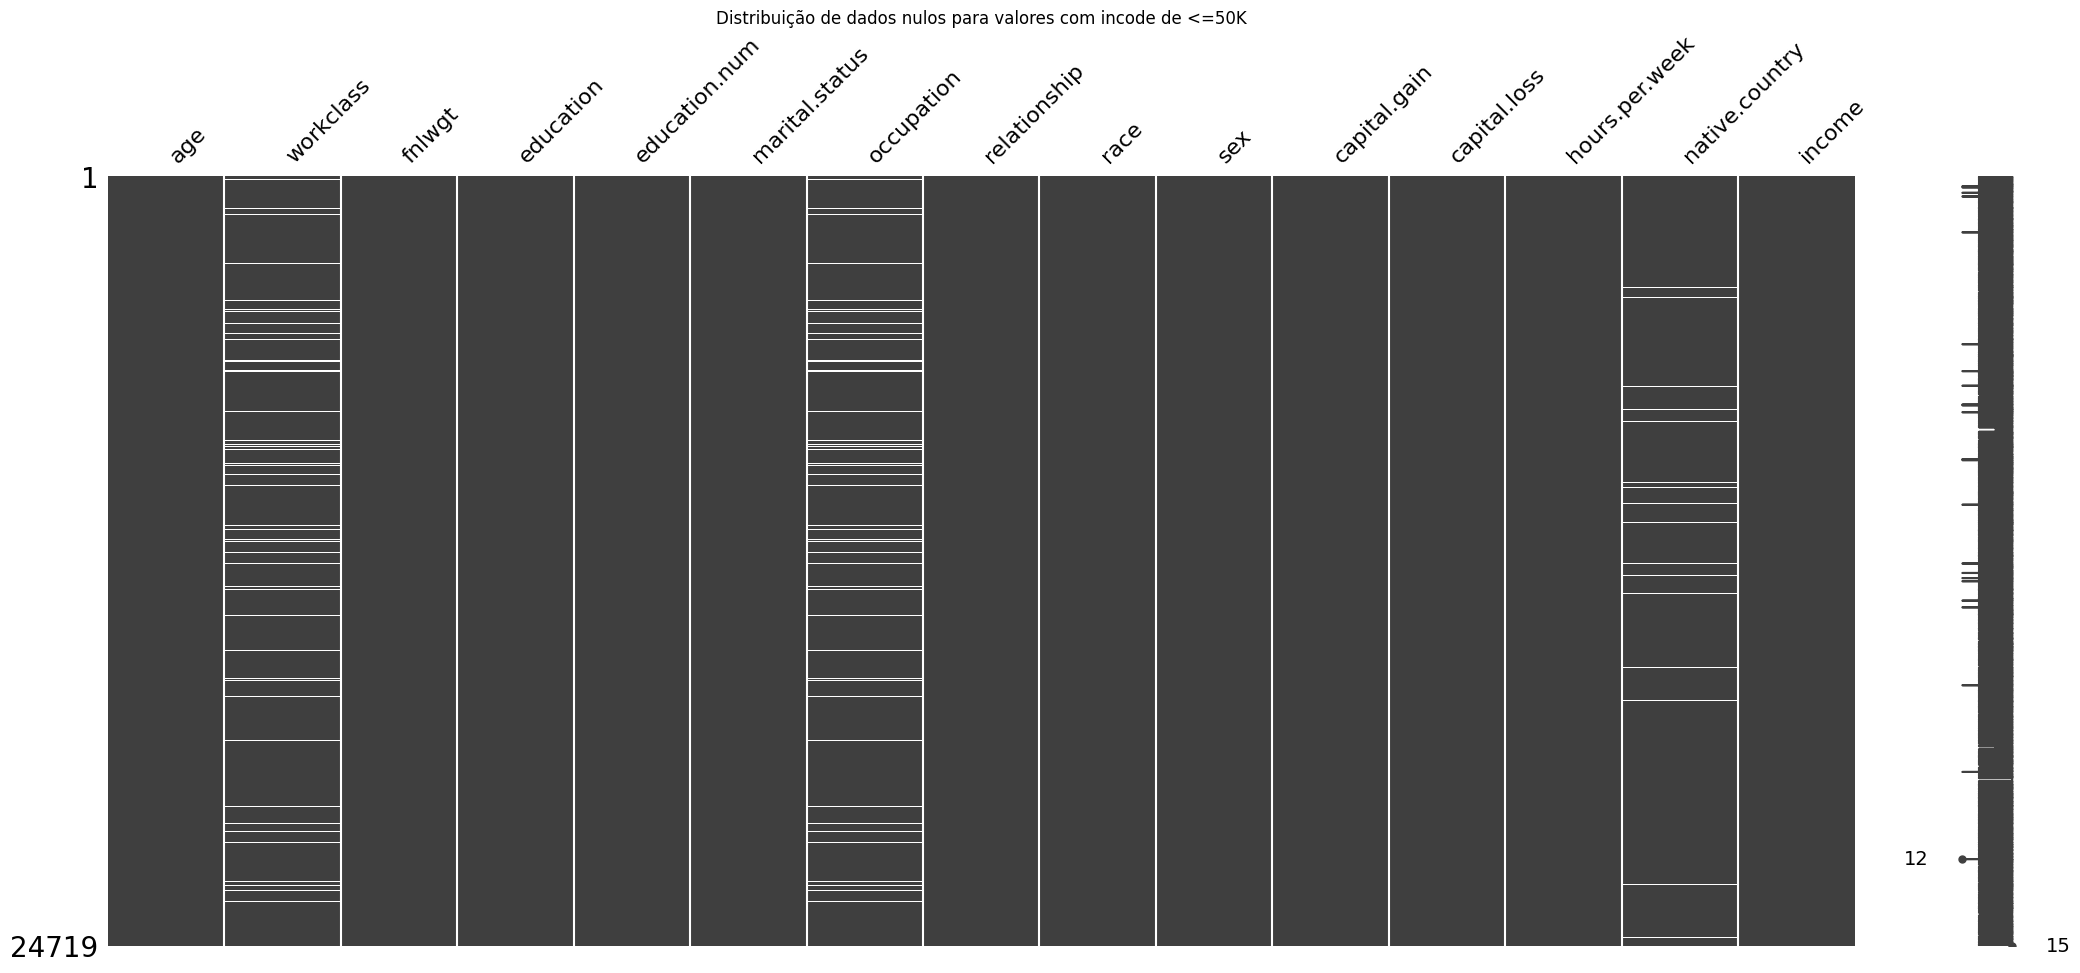

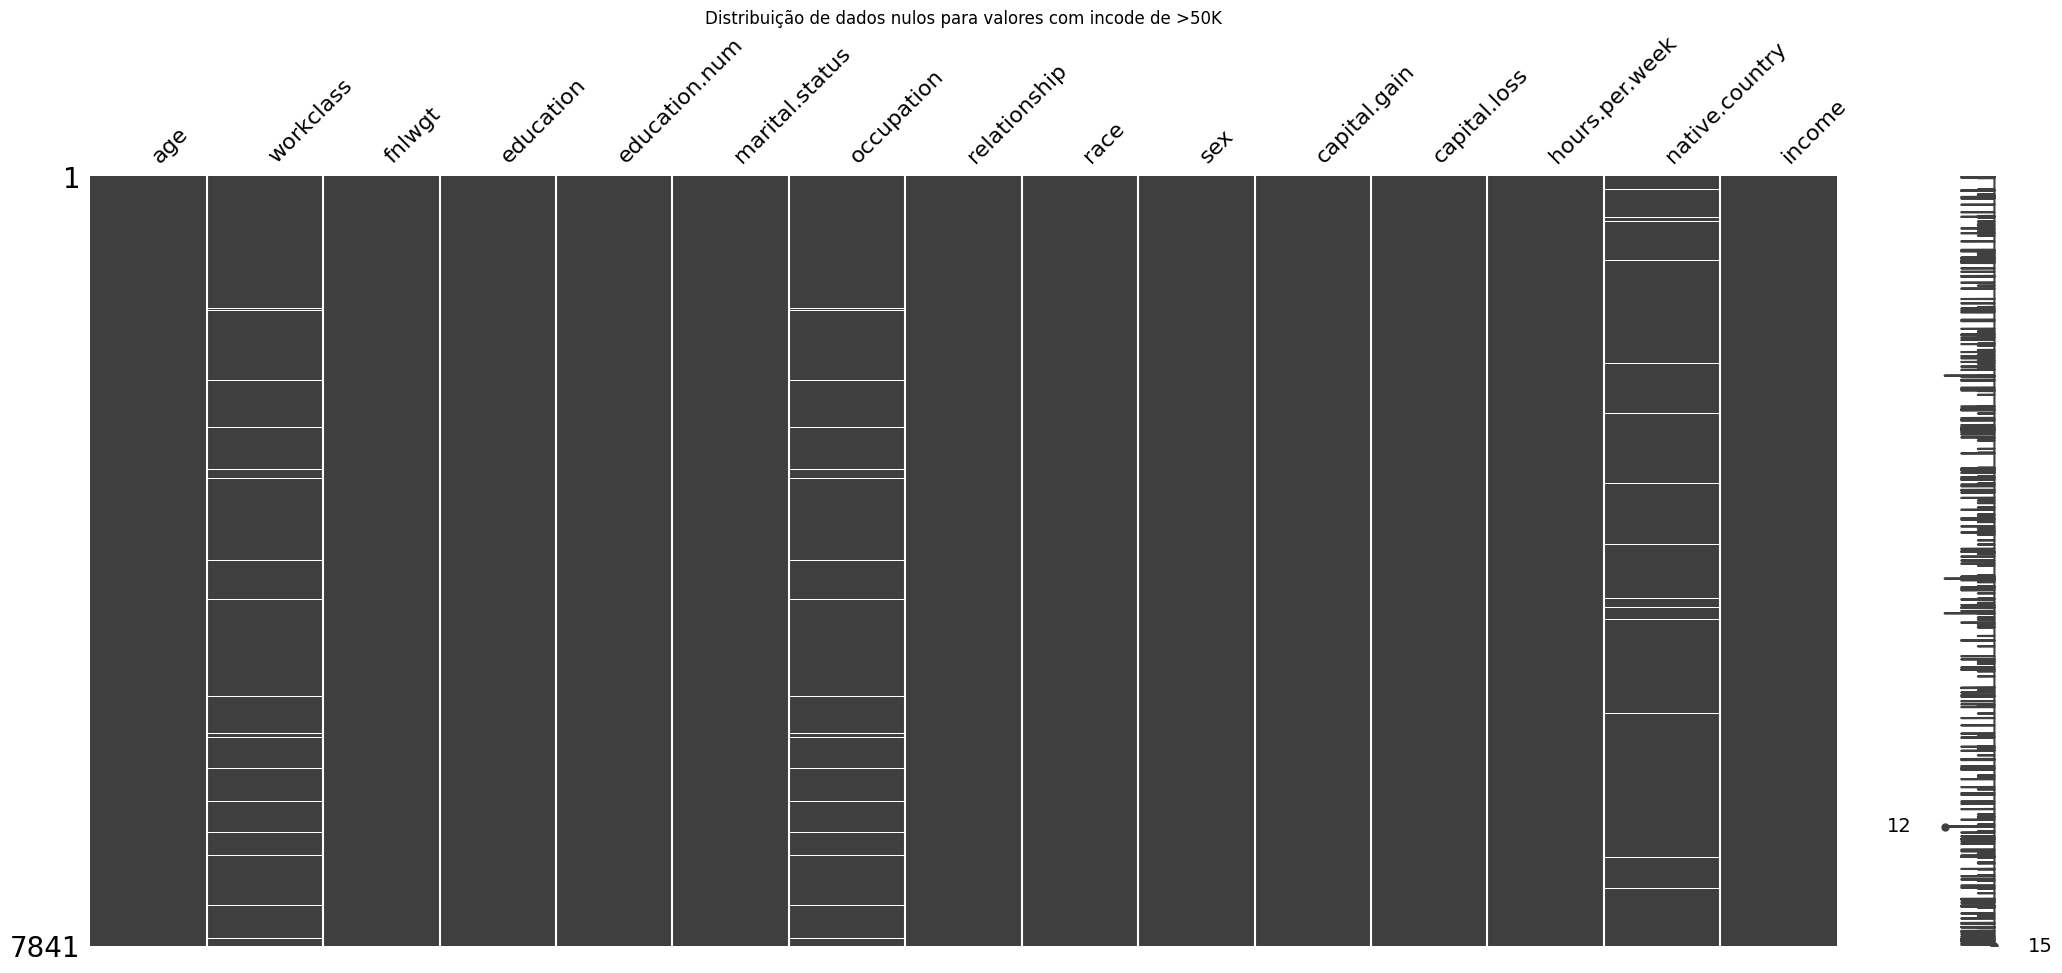

In [67]:
m1 = msno.matrix(adult[adult['income'] == '<=50K'])
m1.axes.set_title("Distribuição de dados nulos para valores com incode de <=50K")

m2 = msno.matrix(adult[adult['income'] == '>50K'])
m2.axes.set_title("Distribuição de dados nulos para valores com incode de >50K")

plt.show()

Percebe-se que não há um padrão paraos dados nulos. Logo, pode ser uma estratégia apenas removê-los, já que não são muitos.
Todos os dados nulos envolvem _features_ categóricas

## Analisando as features numéricas

In [69]:
adult.describe().T

,count,mean,std,min,25%,50%,75%,max
age,32560.0,38.581634,13.640642,17.0,28.0,37.0,48.0,90.0
fnlwgt,32560.0,189781.814373,105549.764924,12285.0,117831.5,178363.0,237054.5,1484705.0
education.num,32560.0,10.080590,2.572709,1.0,9.0,10.0,12.0,16.0
capital.gain,32560.0,1077.615172,7385.402999,0.0,0.0,0.0,0.0,99999.0
capital.loss,32560.0,87.306511,402.966116,0.0,0.0,0.0,0.0,4356.0
hours.per.week,32560.0,40.437469,12.347618,1.0,40.0,40.0,45.0,99.0


- Percebe-se que há a presença de muitos outliers no campo de capital gain e de capital loss
- No campo de hours.per.week, é possível perceber que o valor máximo é bem alto, sendo algo que pode ser interessante analisar

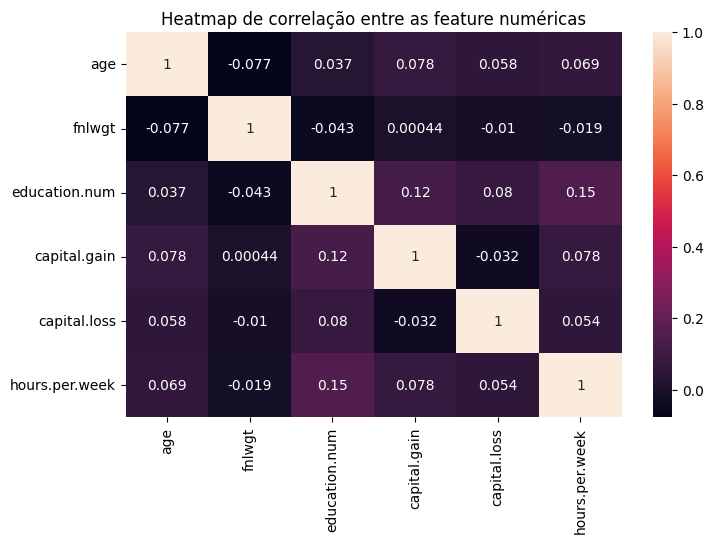

In [84]:
plt.figure(figsize=(8, 5))
plt.title("Heatmap de correlação entre as feature numéricas")
sns.heatmap(adult.select_dtypes(include=['int64']).corr(), annot=True)
plt.show()

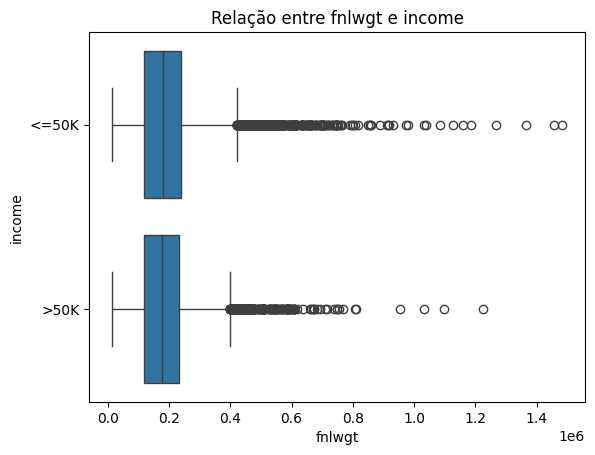

In [422]:
plt.title("Relação entre fnlwgt e income")
sns.boxplot(adult, x='fnlwgt', y='income')
plt.show()

Dá própria definição, percebe-se que não existe uma forte relação com o target. Essa feature pode ser removida

Não é possível identificar features extremamente correlacionas entre si que possam prejudicar o modelo

Agora tentaremos analisar a correlação dessas feature numéricas com o target. Começamos analisando as features com distribuições menos uniformes (capital gain e capital loss)

In [210]:
def analyse_capital(capital_type: str):
    fig = plt.figure(constrained_layout=True, figsize=(15,10))
    gs = fig.add_gridspec(2, 2)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])

    column_name = f'capital.{capital_type}'
    
    sns.histplot(adult.loc[adult[column_name] != 0], x=column_name, hue='income', ax=ax1, kde=True)
    ax1.set_title("Densidade de distribuição do ganho de capital")
    
    sns.countplot(adult.loc[adult[column_name] !=0], x='income', ax=ax2)
    ax2.set_title("Pessoas com ganho capital diferente de 0")
    
    sns.countplot(adult.loc[adult[column_name] == 0], x='income', ax=ax3)
    ax3.set_title("Pessoas com ganho capital igual a 0")
    
    plt.show()

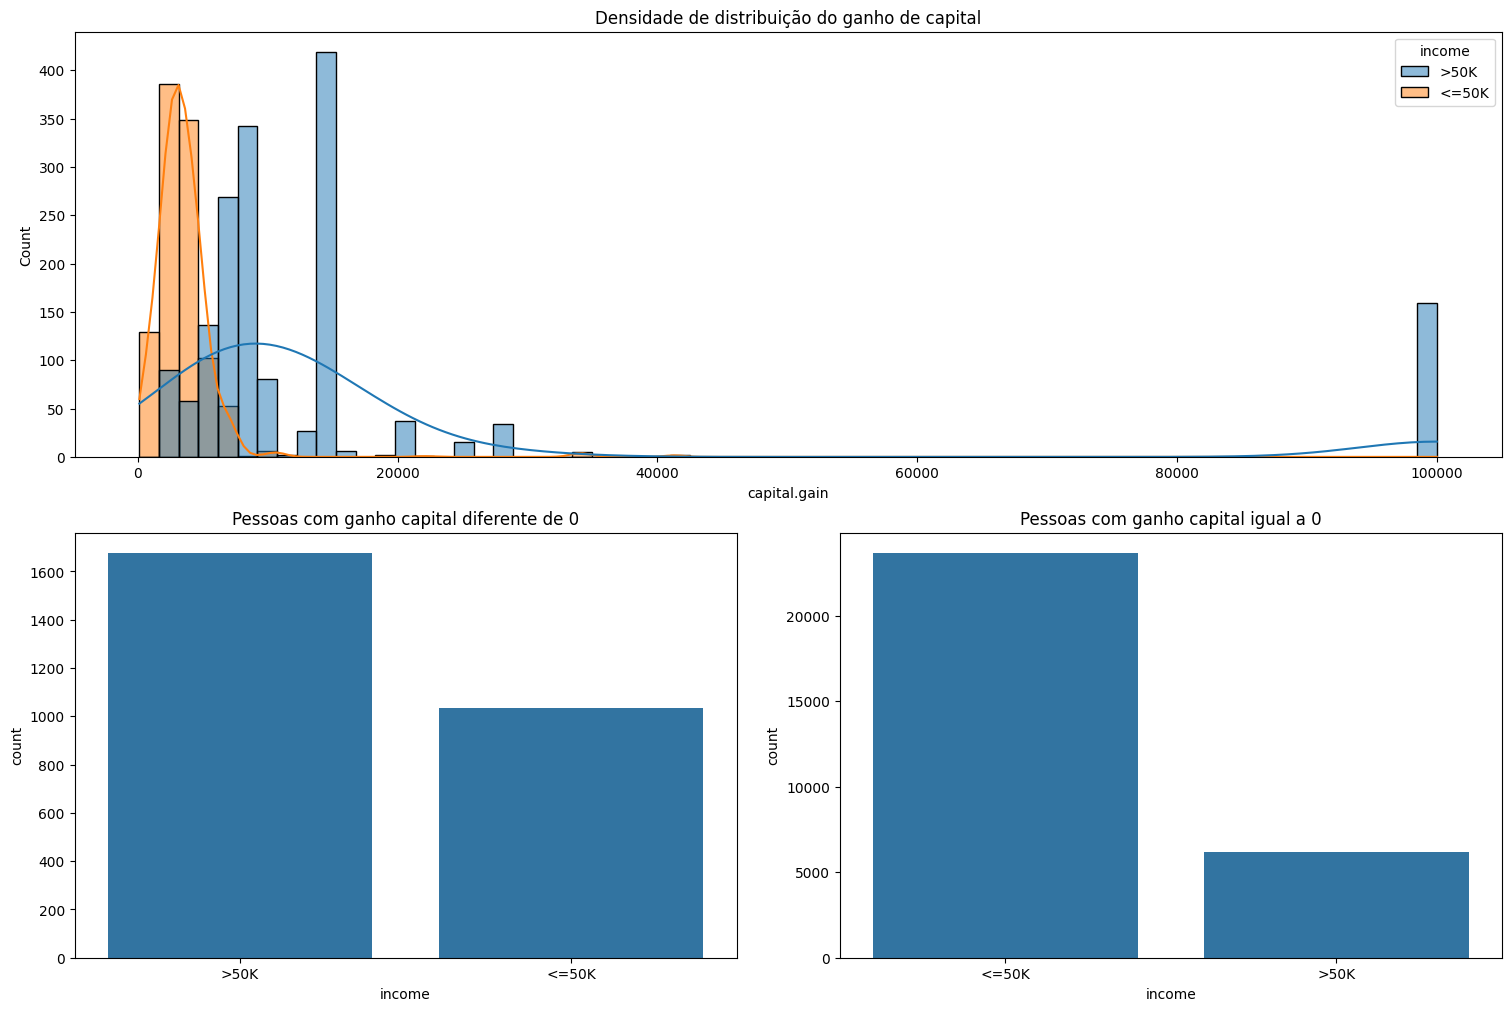

In [211]:
analyse_capital('gain')

Perbece-se que a maioria da pessoas com ganho capital maior que 0 têm renda mais alta, o que pode indicar que é interessante transoformar esta feature em categória com label encoder

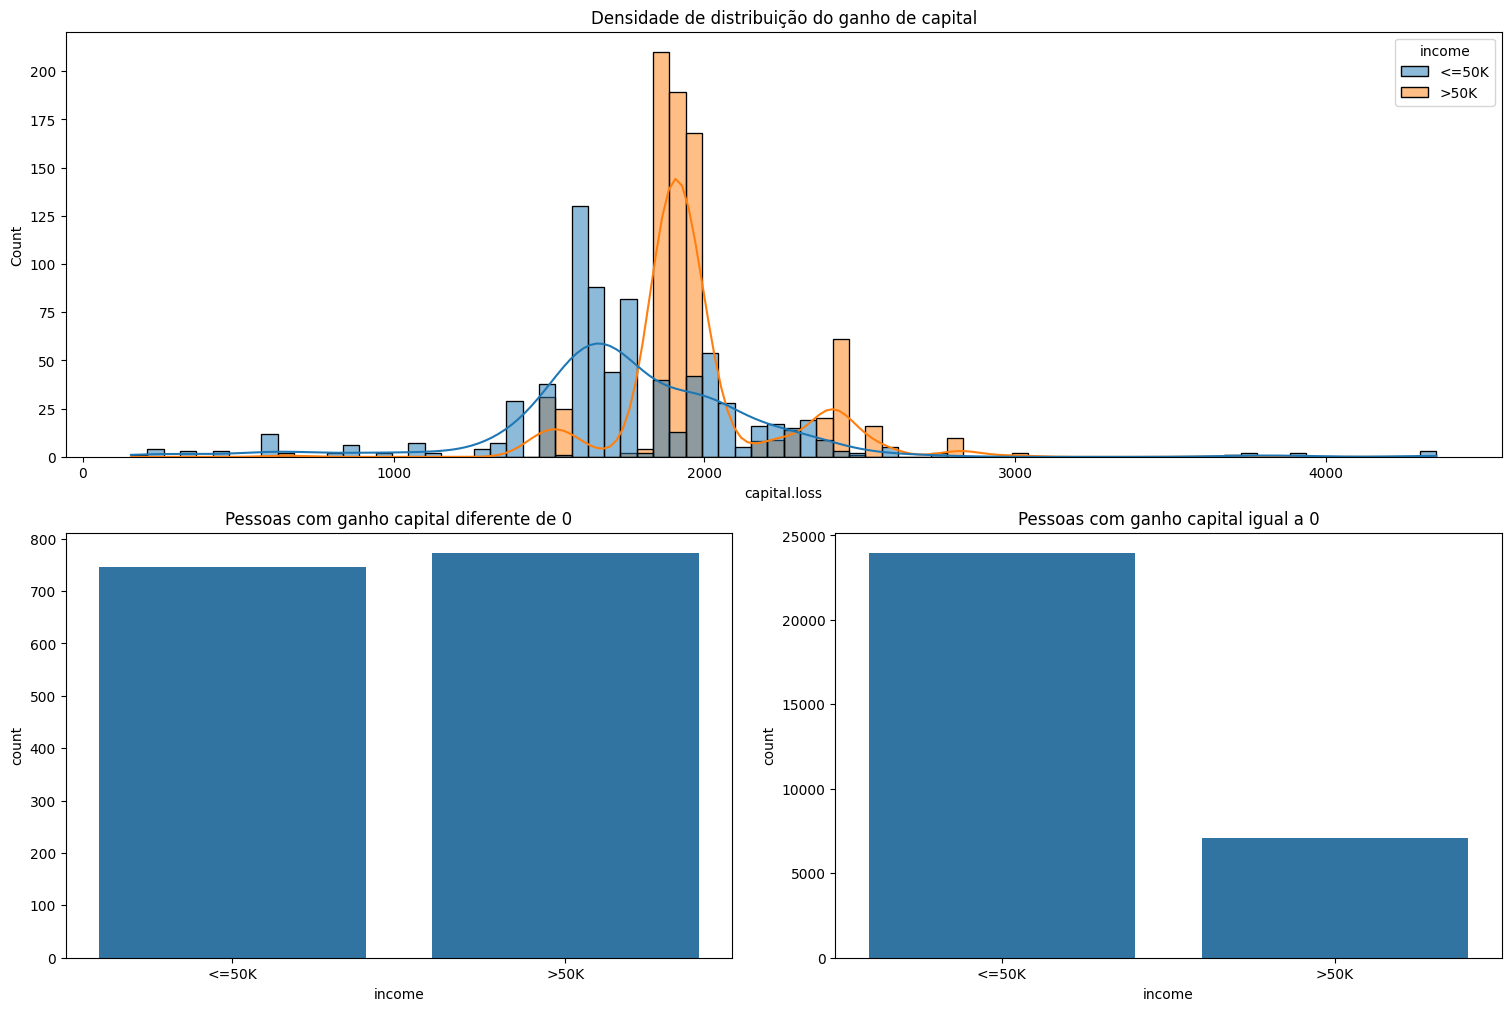

In [212]:
analyse_capital('loss')

No capital loss, não é possível perceber essa relação, o que implica que pode ser interessamte manter a feature numérica, mas trantando seus outliers e normalizando com MinMaxScaler (se remover os outliers) ou RobustScaler (caso sejam removidos os outliers)

In [245]:
def analyse_numeric(column_name, bins='auto'):
    fig, (l1, l2) = plt.subplots(2, 2, figsize=(20, 10))
    sns.histplot(adult, x=column_name, kde=True, ax=l1[0], hue='income', bins=bins)
    l1[0].set_title(f"Distribuição de {column_name} das pessoas")

    title = f"Distribuição de {column_name} em idade em relação à renda das pessoas"
    
    sns.boxplot(adult, x=column_name, y='income', ax=l1[1])
    l1[1].set_title(title)

    sns.stripplot(adult, x='income', y=column_name, ax=l2[0])
    l2[0].set_title(title)

    sns.violinplot(adult, x=column_name, y='income', ax=l2[1])
    l2[1].set_title(title)
    
    plt.show()
    

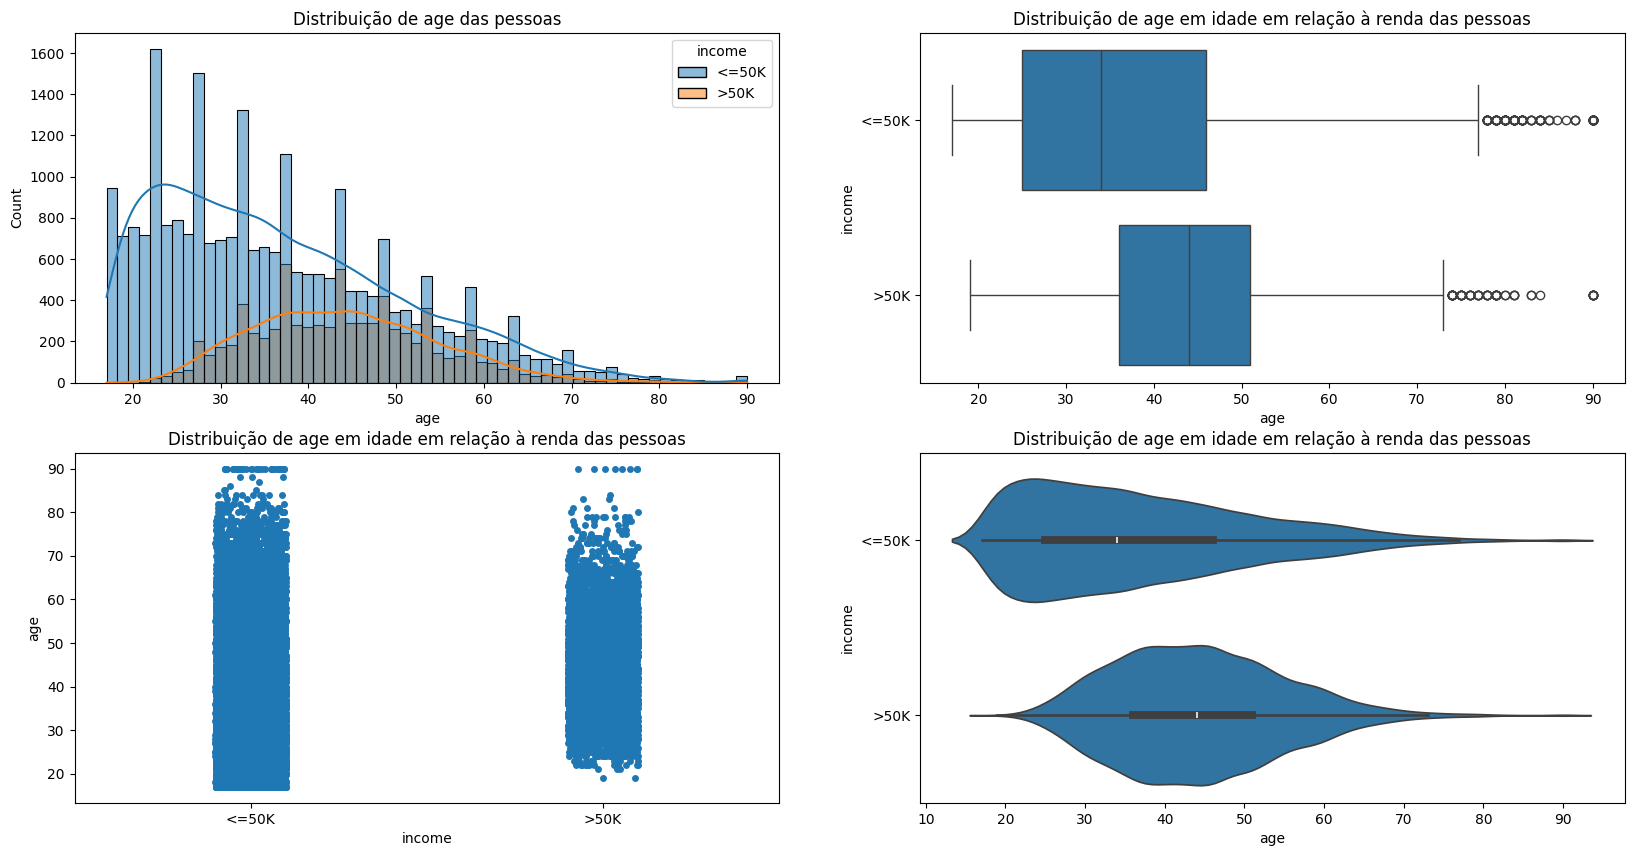

In [246]:
analyse_numeric('age')

É possível perceber uma relação entre a renda e a idade, e, além disso, não há tanto a presença de outliers. Pode ser padronizada com o StandardScaler
Pessoas de baixa renda tendem a ter idades menores. No entanto, é possível tecer o argumento de que isso se deve ao desbalanceamento dos dados, o que pode ser resolvido com _ressampling_

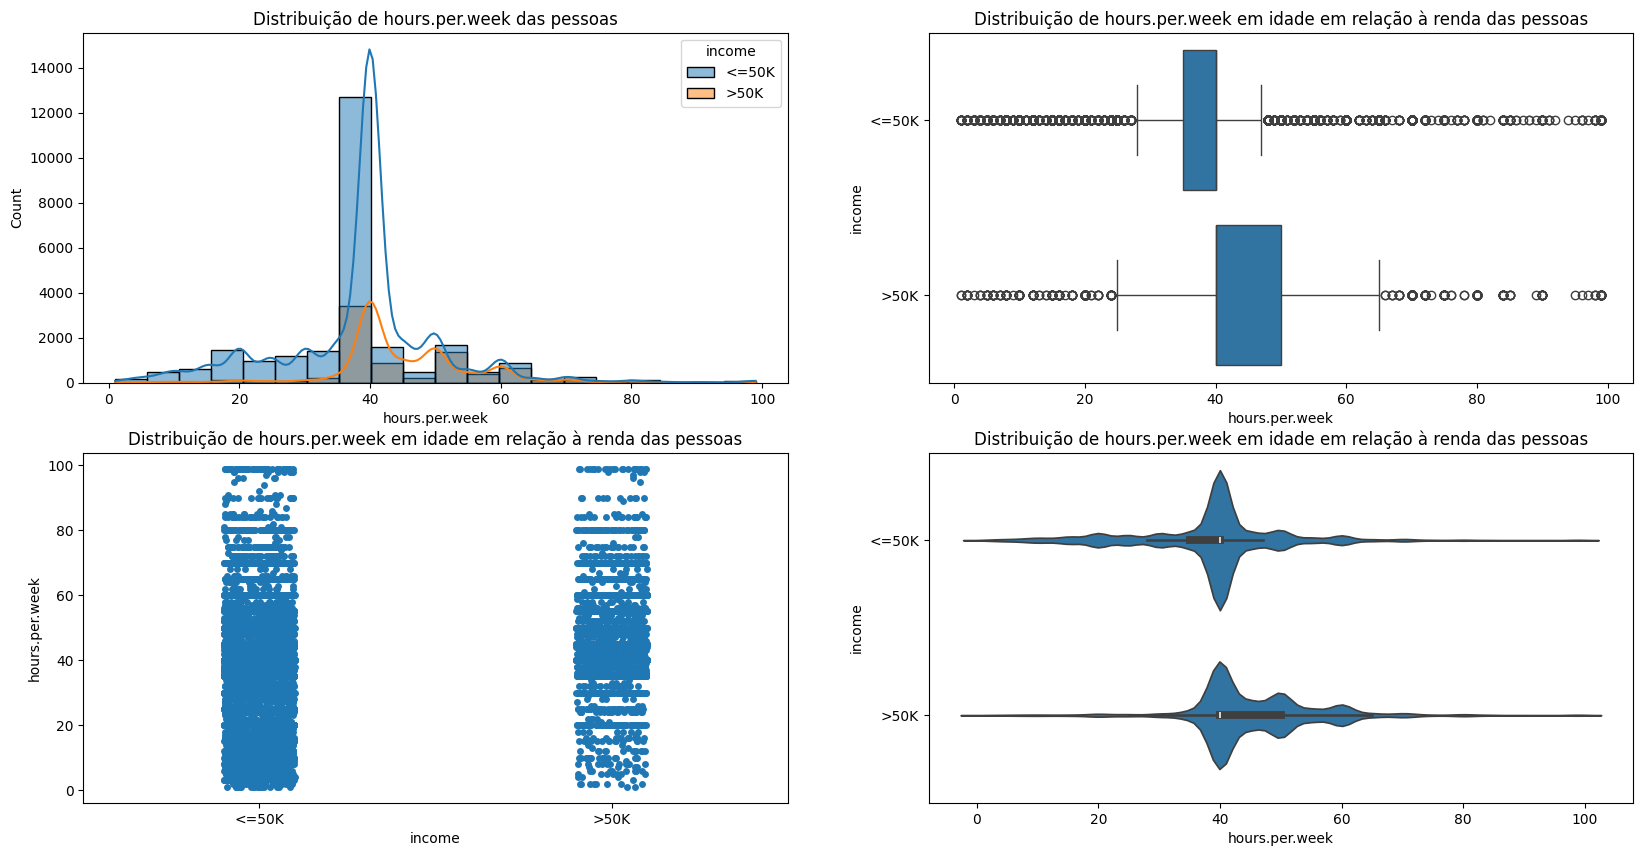

In [248]:
analyse_numeric('hours.per.week', bins=20)

Percebe-se que as pessoas de alta renda têm horas de trabalho mais concetradas de 40 para cima, enquanto isso é muito mais bem distribuído nas pessoas de baixa renda. Vale a pena considerar os outliets, escalando com o RobustScaler

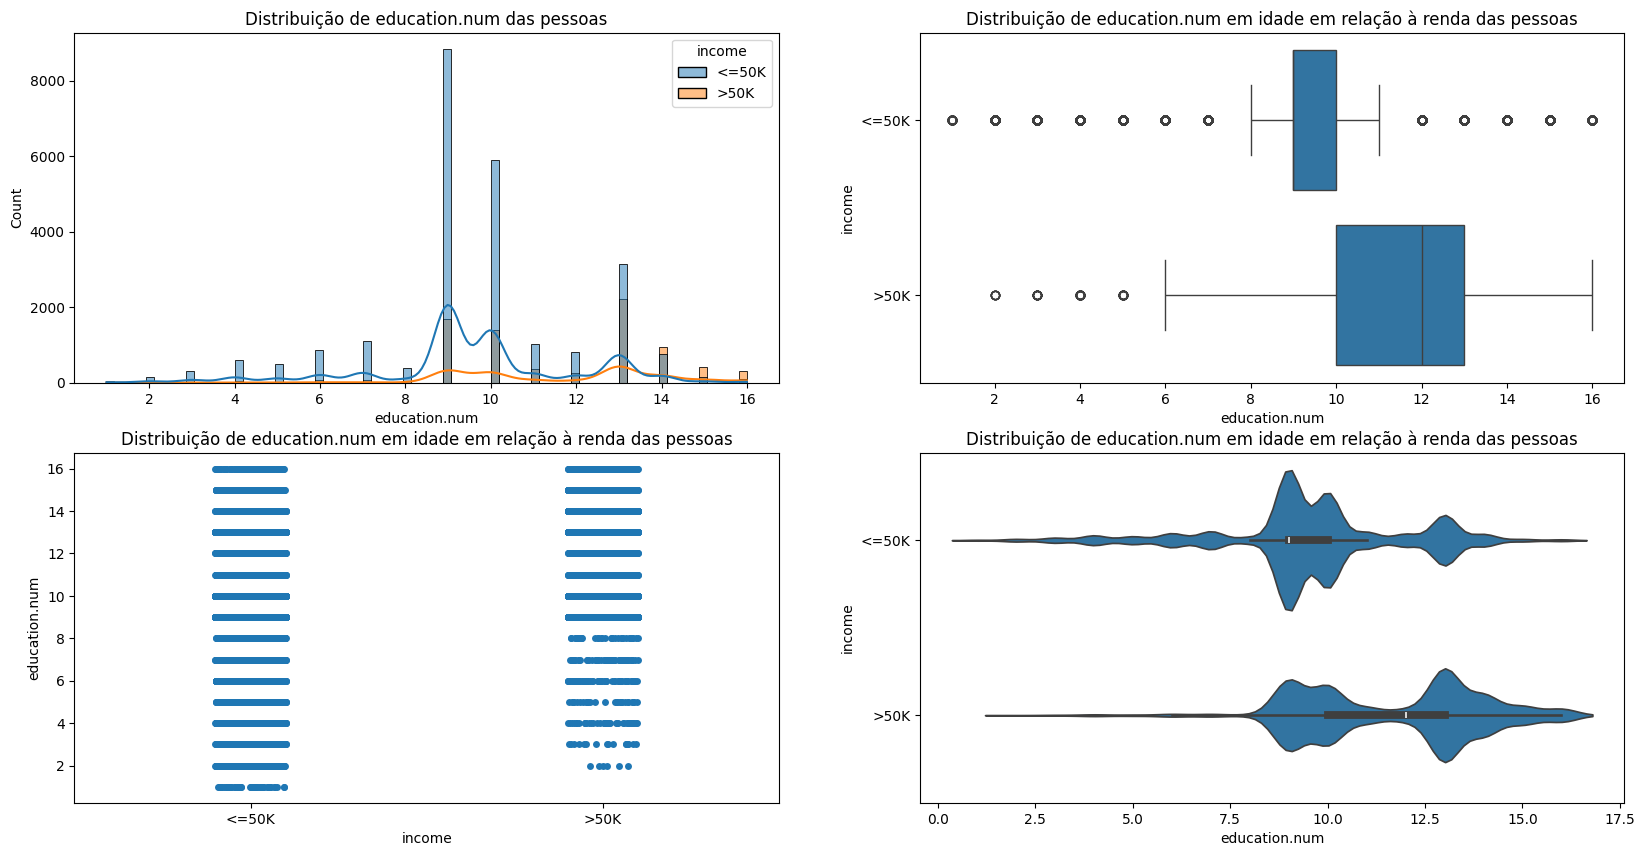

In [249]:
analyse_numeric('education.num')

Percebe-se que as pessoas de alta renda têm mais anos de educação

## Analisando features categórias

In [427]:
def get_count(columns_name, figsize=(10,8), rotate=45):
    plt.figure(figsize=figsize)
    plt.title(f"Quantidade de {columns_name}")
    sns.countplot(adult, x=columns_name, order=adult[columns_name].value_counts().index)
    plt.xticks(rotation=rotate)
    plt.show()

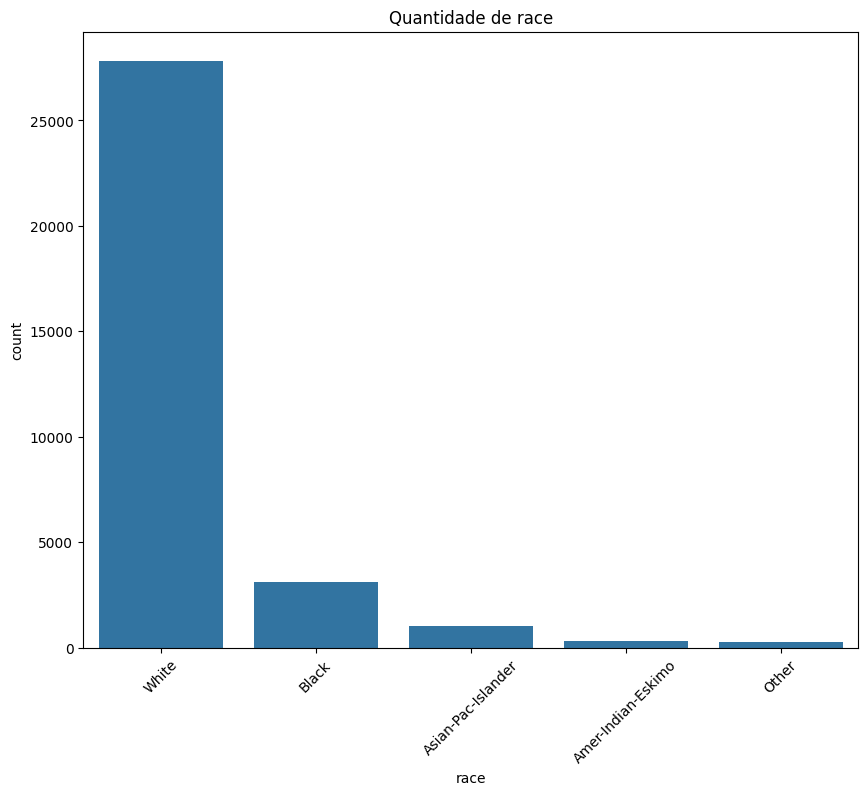

In [415]:
get_count('race')

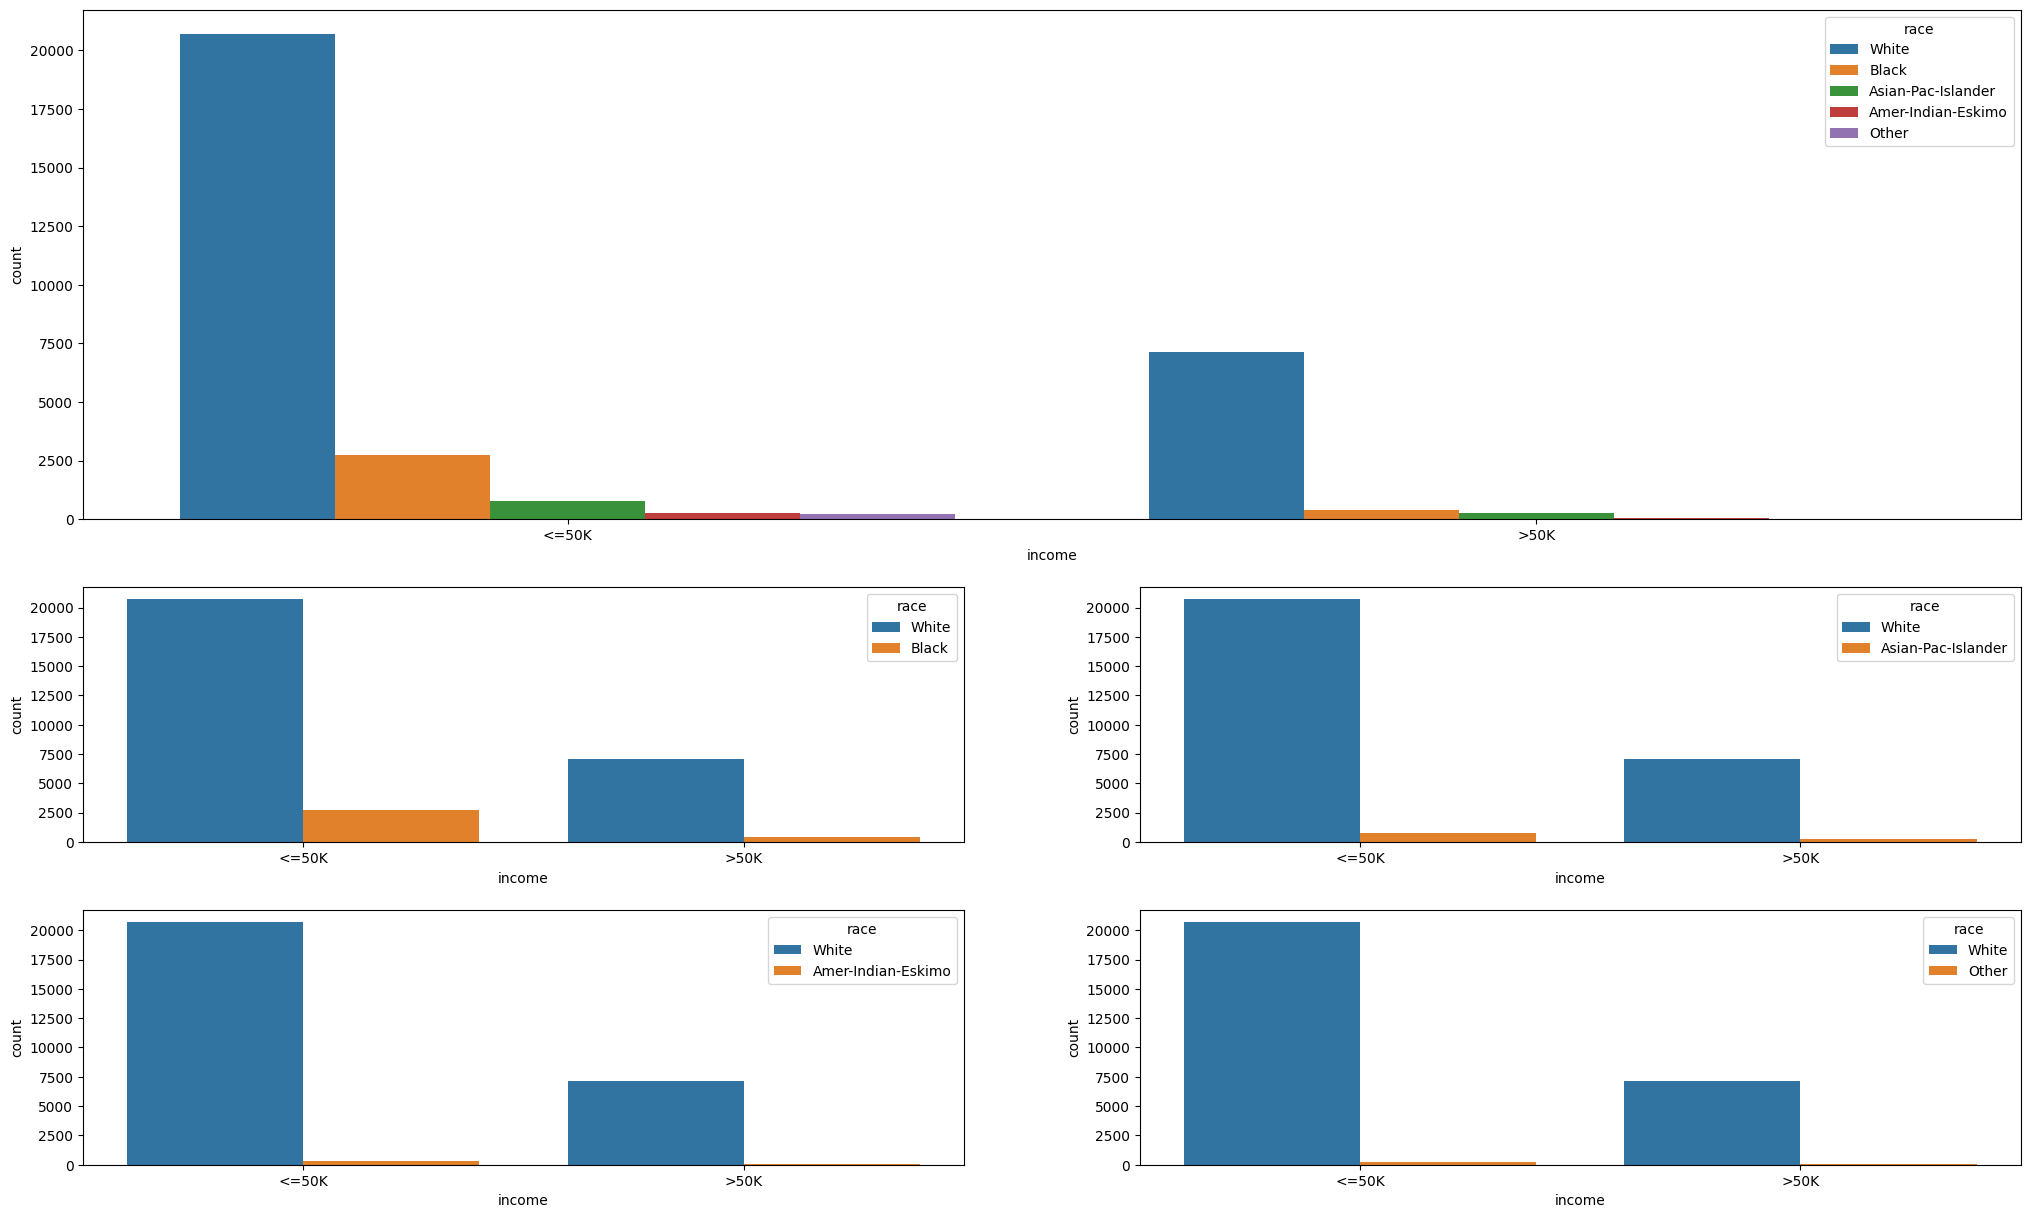

In [289]:
fig = plt.figure(figsize=(25, 15))
gs = fig.add_gridspec(3, 2, height_ratios=[2, 1, 1])
sns.countplot(adult, x='income', hue='race', ax=fig.add_subplot(gs[0, :]))
i = 1 
j = 0
for race in adult['race'].unique():
    if race == 'White':
        continue
    sns.countplot(adult.loc[adult['race'].isin(['White', race])], x='income', hue='race', ax=fig.add_subplot(gs[i, j]))
    j += 1
    if j > 1:
        i += 1
        j = 0
        

Percebe-se que as únicas etnias que realmente estão mais presentes é "White" e "Black". Vamos ver como a renda muda por etnia

In [365]:
def get_proportion_by_income(column_name):
    less = adult.loc[adult['income'] == '<=50K']
    greater = adult.loc[adult['income'] == '>50K']
    less_prop = less[column_name].value_counts() / less.shape[0]
    greater_prop = greater[column_name].value_counts() / greater.shape[0]
    return less_prop.sort_values(ascending=False), greater_prop.sort_values(ascending=False)

In [406]:
def plot_proportion_by_income(column_name, figsize=(20,6)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    less_prop, greater_prop = get_proportion_by_income(column_name)
    less_prop.plot(kind='bar', ax=ax1)
    ax1.set_title(f"Proporção de {column_name} para pessoas de baixa renda") 
    greater_prop.plot(kind='bar', ax=ax2)
    ax2.set_title(f"Proporção de {column_name} para pessoas de alta renda") 

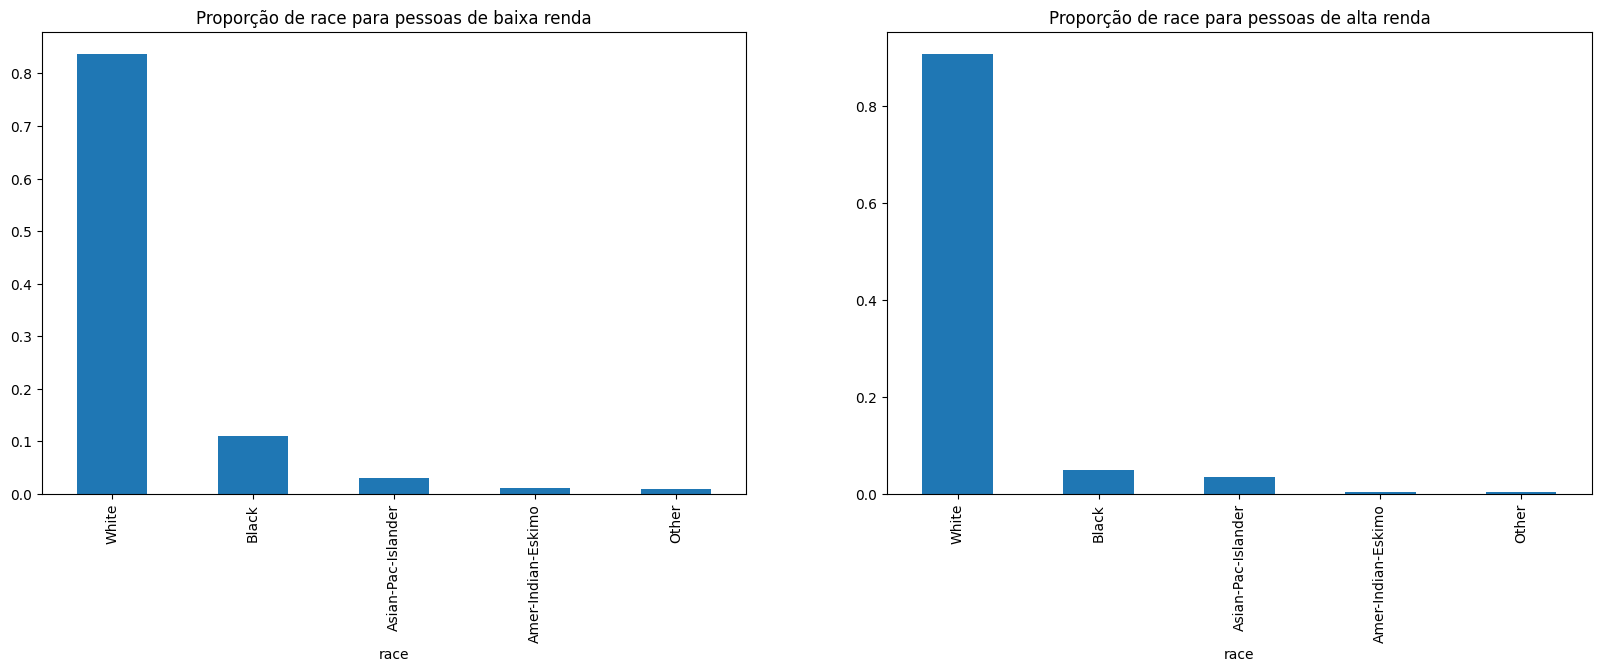

In [407]:
plot_proportion_by_income('race')

A mudança mais expressiva para o target se dá em função das etnias "White" e "Black", o que implica que as categorias podem ser reduzidas para
- White
- Black
- Other

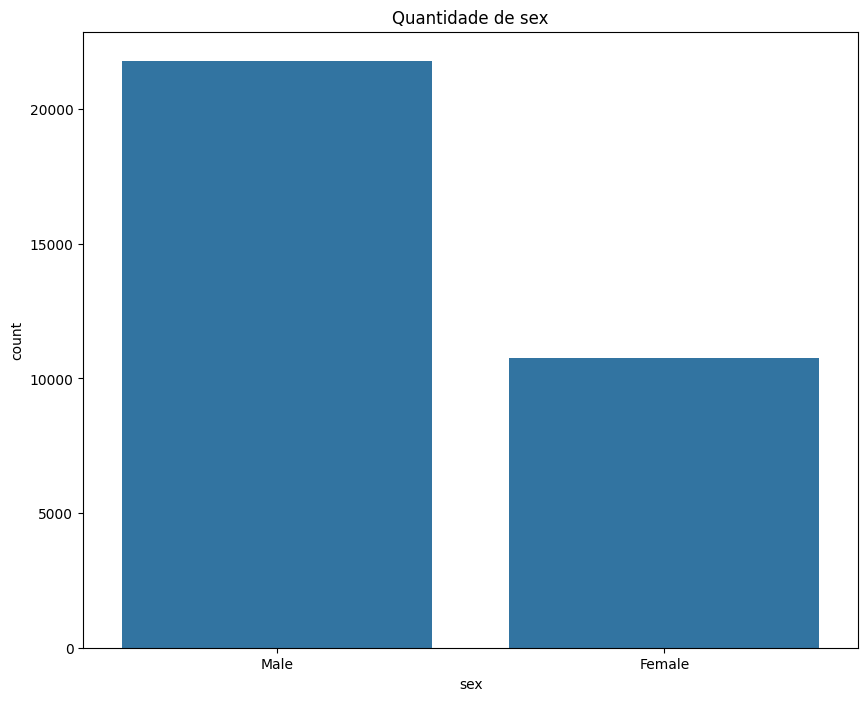

In [388]:
get_count('sex')

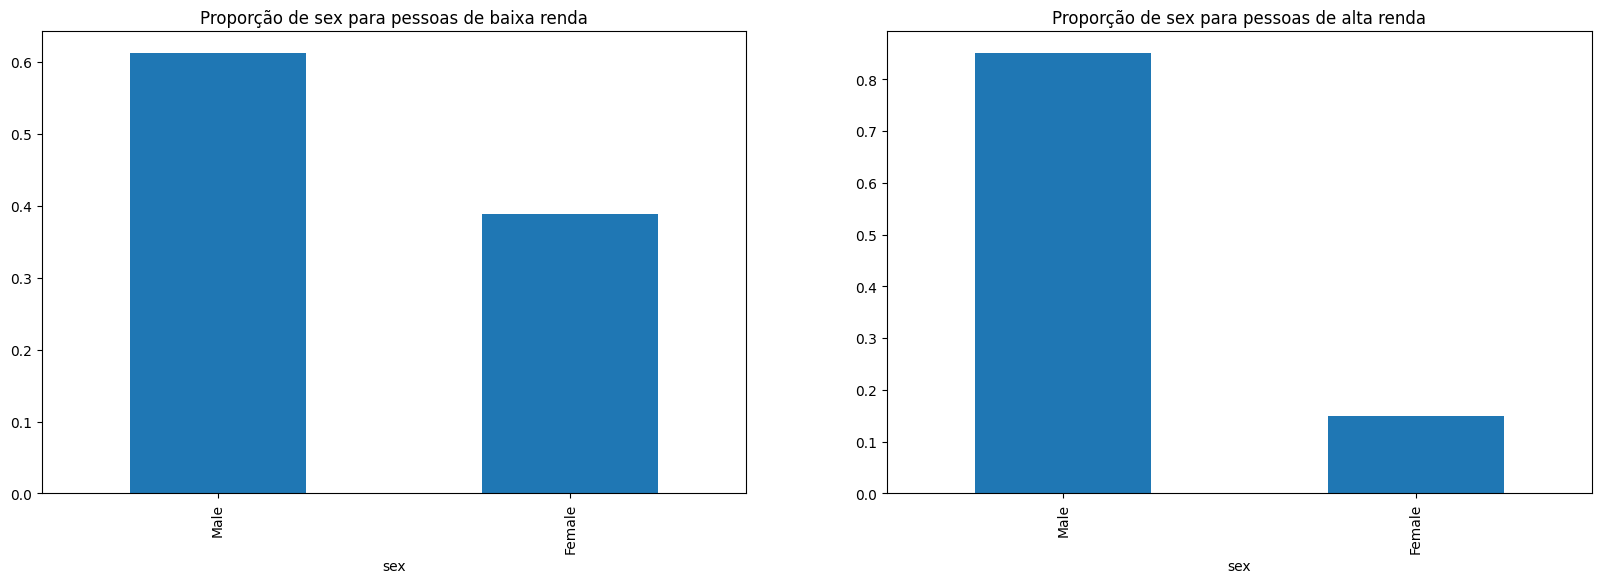

In [408]:
plot_proportion_by_income('sex')

Percebe-se uma grande influência do sexo na proporção em relação a renda, o que também pode ser causado pro desbalanceamento, já que há menos mulheres registradas 

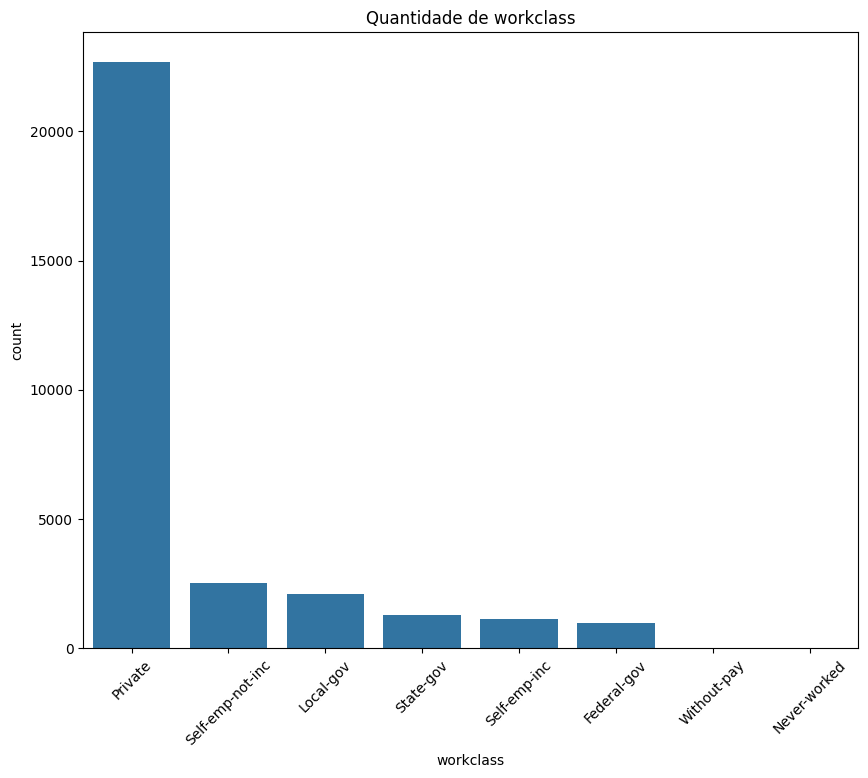

In [416]:
get_count('workclass')

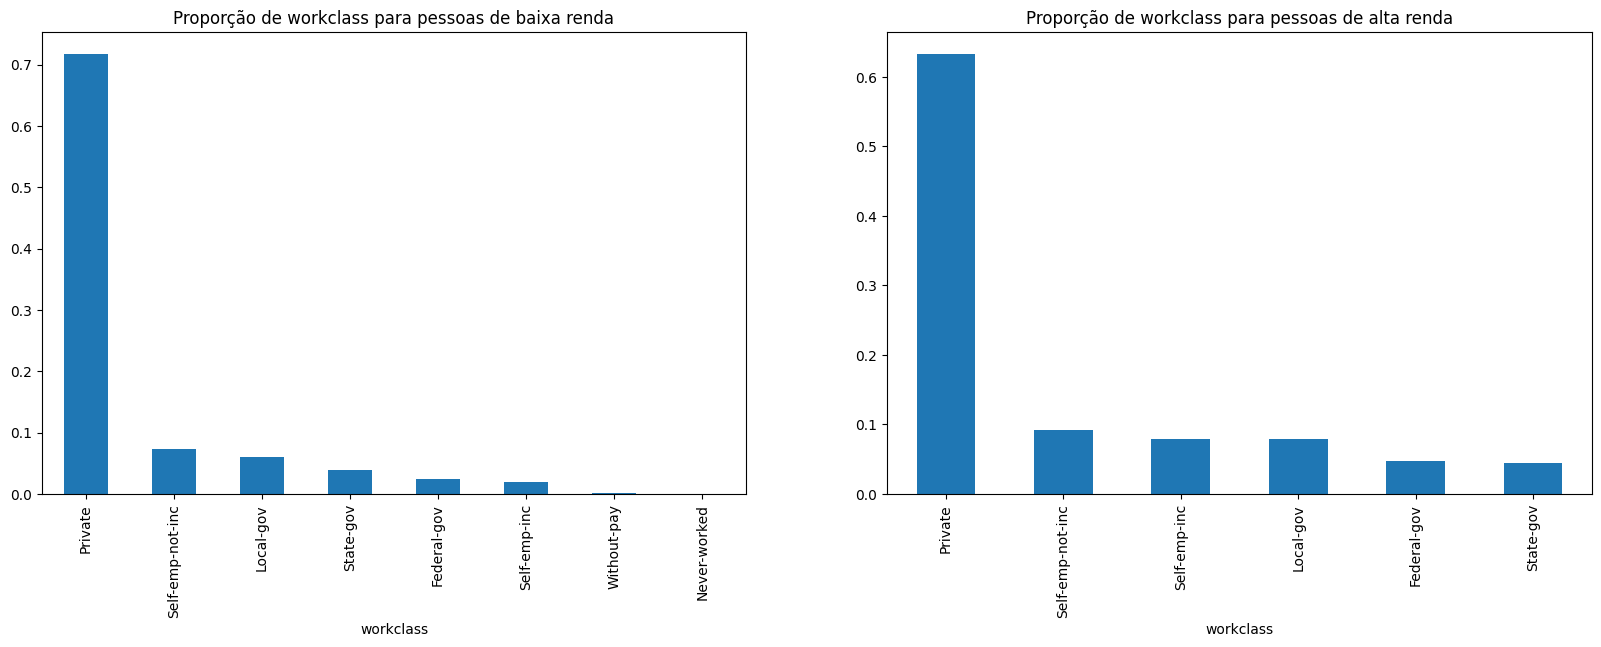

In [409]:
plot_proportion_by_income('workclass')

Percebe-se uma grande influência da workclass, que deve ser tratada com OneHotEncoding

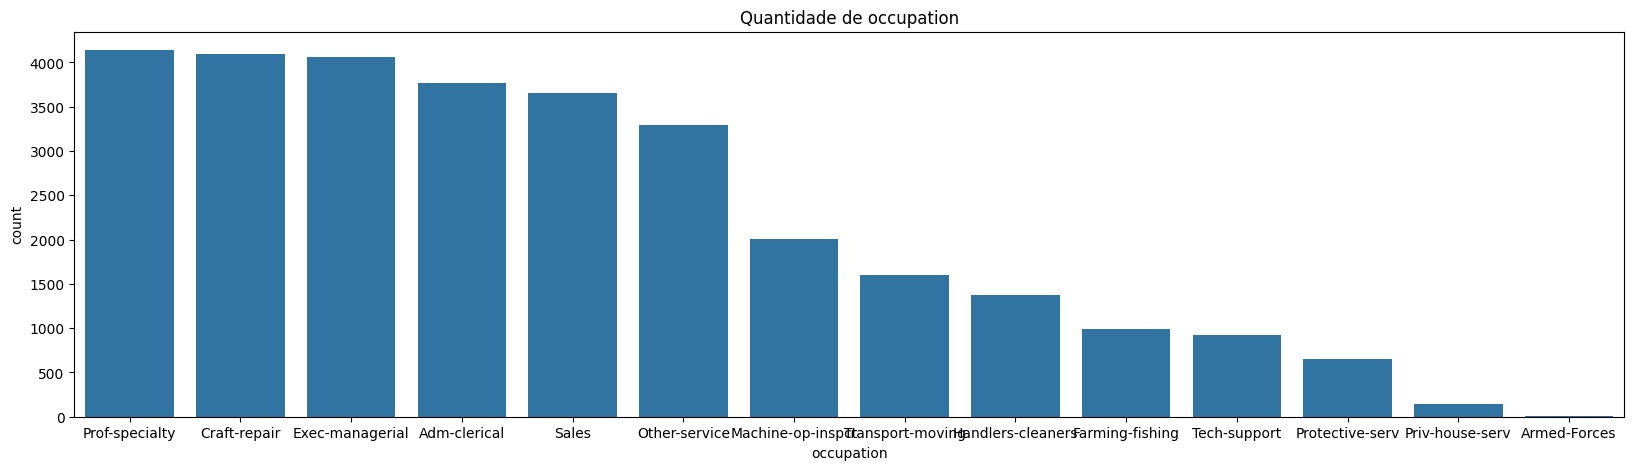

In [403]:
get_count('occupation', figsize=(20,5))

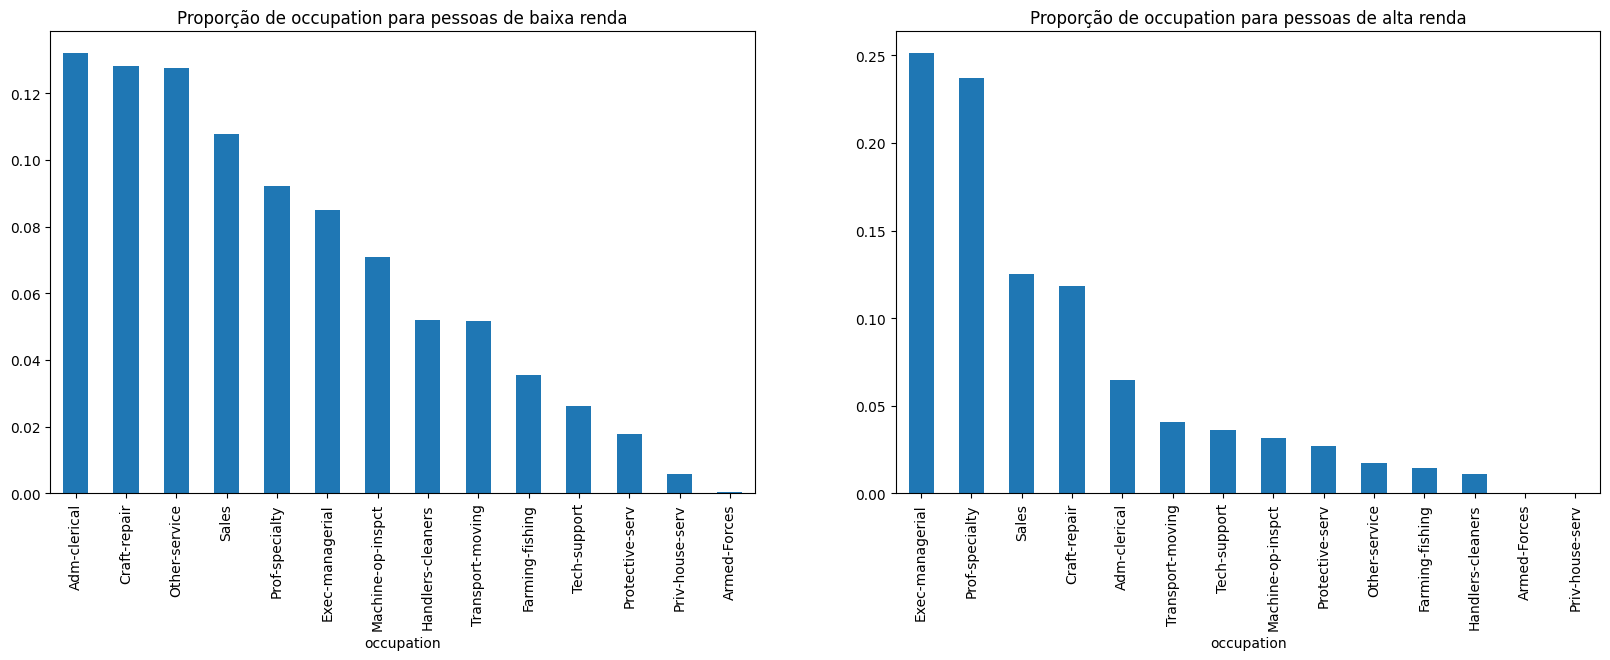

In [410]:
plot_proportion_by_income('occupation')

É evidente a influência da ocupação. Feature deve ser tratata com OneHotEncoder

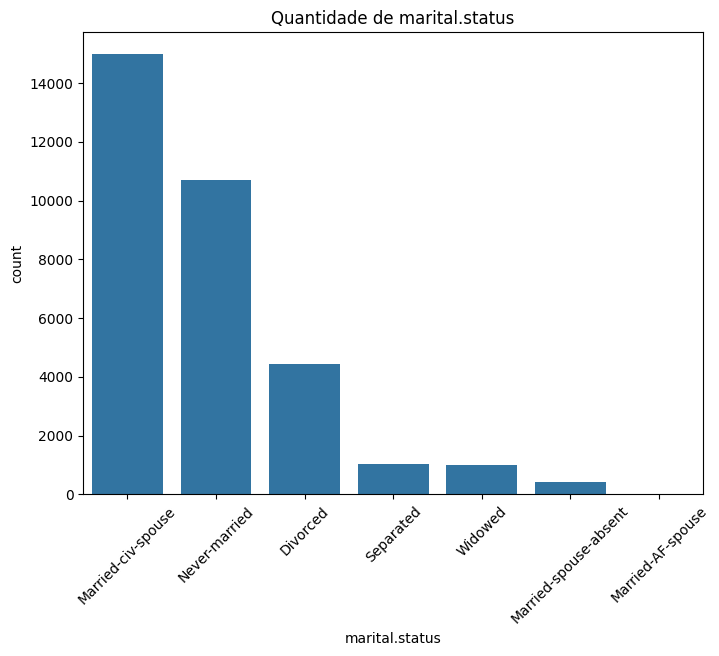

In [419]:
get_count('marital.status', figsize=(8,6))

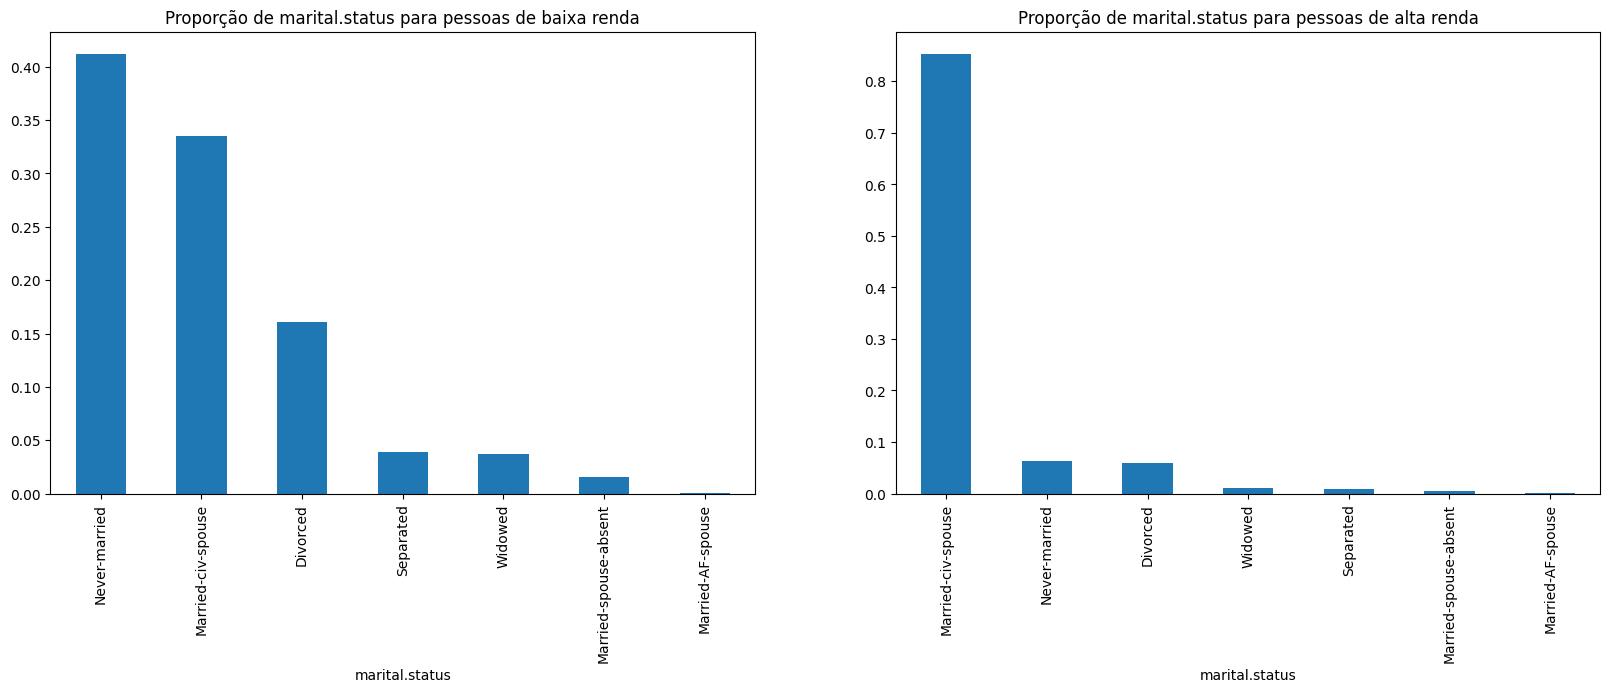

In [420]:
plot_proportion_by_income('marital.status')

Depois vale a pena testar a teoria de de separar em 4 categorias:
- Never-married
- Married
- Divorced/Separeted
- Others

Depois, ela deve ser tratada com OneHotEncoder, pois não há noção de ordem

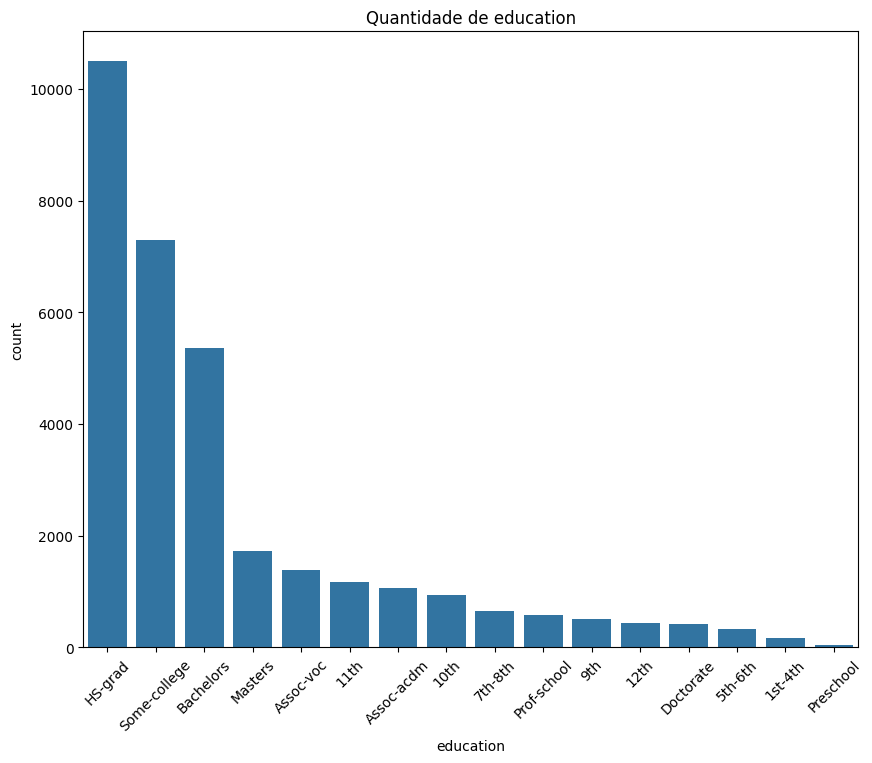

In [423]:
get_count('education')

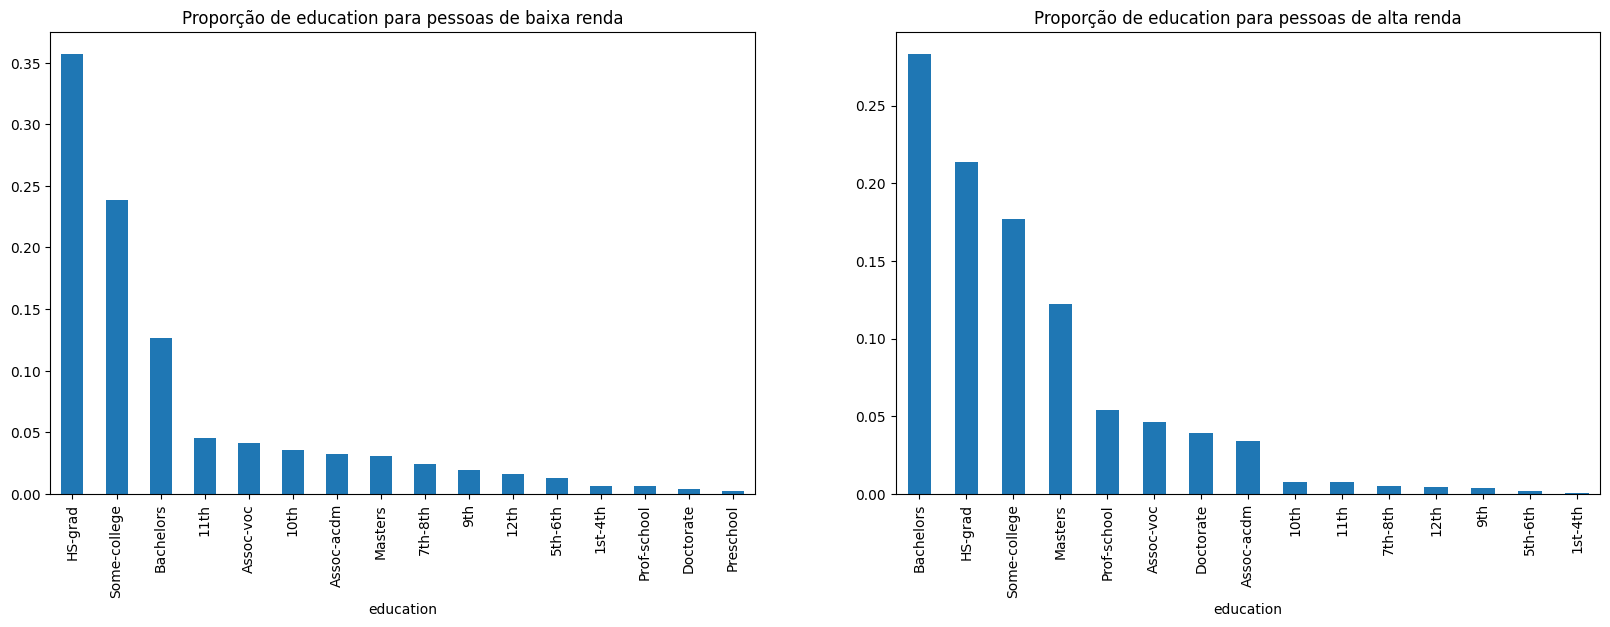

In [424]:
plot_proportion_by_income('education')

Essa feature tem bastante influência, é possível tratá-la com LabelEncoder, pois há noção de ordem

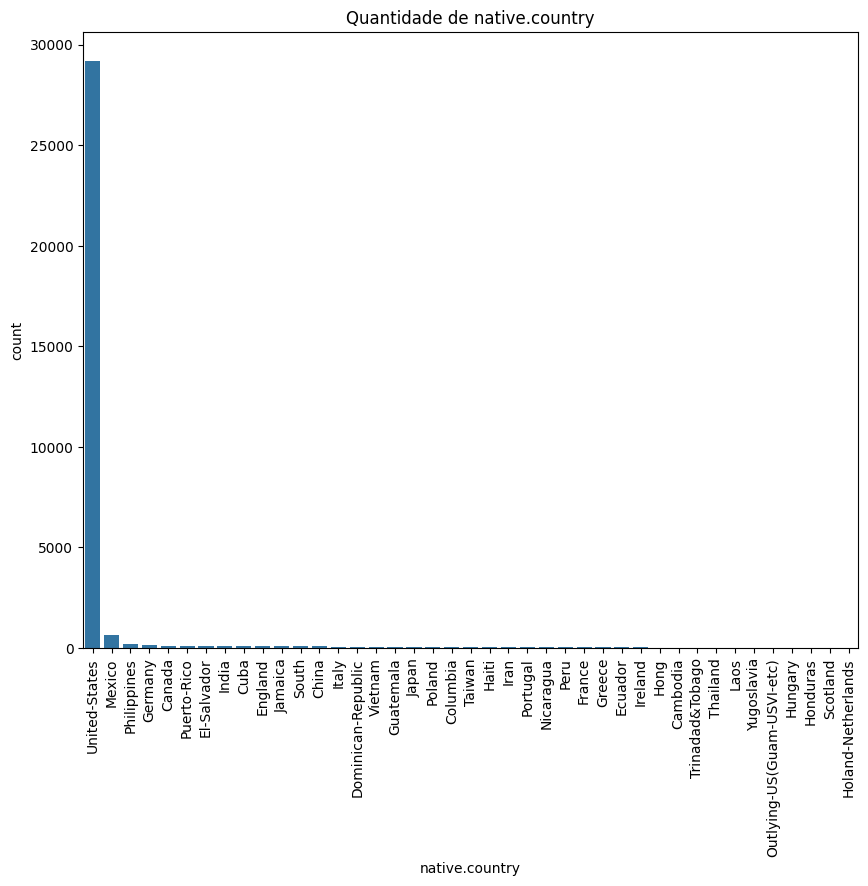

In [428]:
get_count('native.country', rotate=90)

Percebe-se que há muitos valores com baixa representatividade, vale a pena simplificr tratando como:
- United-States
- Not United States

# Predição

Os dados serão tratador de acordo com o que foi estipulado na análise exploratória e serão testadas as seguintes estratégias:
- Com oversampling, com undesampling e sem tratamento de desbalanceamento
- Removendo os dados nulos ou imputando os dados nulos com SimpleImputer ou KNNImputer